In [1]:
import tensorflow as tf
from tensorflow import keras
import random
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, clear_output
import time
from multiprocessing.dummy import Pool
from sklearn.preprocessing import MinMaxScaler
from sumtree import SumTree

# generate generic dataseries of 'price' movements over a 130 day period
data = np.sin(np.arange(0,20,0.1))
data = data.reshape(len(data),1)
scaler = MinMaxScaler()
scaler = scaler.fit(data)
data = scaler.transform(data)
data = data.reshape(1,len(data))[0] + 1

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [2]:
# custom loss function as per https://www.freecodecamp.org/news/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682/

def IS(y_true, y_pred, is_weight):
    return is_weight * keras.losses.mean_squared_error(y_true, y_pred)
    

# build deep recurrent model with keras and LSTM
def buildmodel(is_train):
    x = keras.layers.Input(shape=(60,1), name="prices_in")
    y_true = keras.layers.Input(shape=(2,), name="y_true")
    if is_train:
        is_weight = keras.layers.Input(shape=(1,), name="is_weight")
    f = keras.layers.GRU(60, return_sequences=True)(x)
    f = keras.layers.GRU(20, return_sequences=True)(f)
    f = keras.layers.Flatten()(f)
    y_pred = keras.layers.Dense(2, activation=tf.nn.leaky_relu, name="y_pred")(f)
    if is_train:
        model = keras.models.Model(inputs = [x,y_true,is_weight], outputs=y_pred, name="train_only")
        model.add_loss(IS(y_true, y_pred, is_weight))
        model.compile(loss=None, optimizer="adam")
        print(model.summary())
    else:
        model = keras.models.Model(inputs = x, outputs=y_pred, name="predict")
        model.compile(loss="mse", optimizer="adam")
        print(model.summary())
    
    return model

# call model
model_train = buildmodel(is_train=True)
model_predict = buildmodel(is_train=False)

W0731 08:39:43.087705 140715111384896 deprecation.py:506] From /home/jahan/miniconda3/envs/ml_cpu/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0731 08:39:43.535642 140715111384896 training_utils.py:1101] Output y_pred missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to y_pred.


Model: "train_only"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
prices_in (InputLayer)          [(None, 60, 1)]      0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 60, 60)       11160       prices_in[0][0]                  
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 60, 20)       4860        gru[0][0]                        
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1200)         0           gru_1[0][0]                      
_________________________________________________________________________________________

In [3]:
#print(np.expand_dims(np.array([data[0:60]]),2).reshape(60,1))
print(model_predict.predict(np.expand_dims(np.array([data[0:60]]),2)))
print(np.argmax(model_predict.predict(np.expand_dims(np.array([data[0:60]]),2))))
print(np.max(model_predict.predict(np.expand_dims(np.array([data[0:60]]),2))))

[[-0.02102647 -0.05163283]]
0
-0.021026473


In [4]:
# functions to process dataframe to run through above
def prep_targets(pred_s,pred_s1,a_vals,r_vals ):
    y =np.empty([0,2])
    for i in range(len(a_vals)):
        a = a_vals[i]
        r = r_vals[i]
        if a == 0: # if action is sell
            temp = [r + 0.9*np.max(pred_s1[i]), pred_s[i][1]]
        else: # if a == 1 aka buy
            temp = [pred_s[i][1],r + 0.9*np.max(pred_s1[i])]
        y = np.append(y,np.array(temp))       
    return y

In [5]:
# cell to design training function

# there are 2^step possible sets of choices. We'll start random walking, 
# training our algorithm stochastically,
# as well as batch learning once our experience replay dict get large enough

# inputs to function are as follows
# epoch is number of cycles
# batch_size is size of batch to train from experience replay dataset
# mod is reward modifier 
# gamma is gamma setting
# prob is random walk probability

def training_function(epoch,batch_size,step,mod,gamma,prob):
    # dataframe to save experience replay shenanigans
    replay = SumTree(10000)
    # training metrics
    losses = [0]
    values = [0]
    # initialise eta parameter
    eta = 0
    epoch_time = 0
    small = True # value for checking whether to do batch learn
    # start epoch loop
    for its in range(epoch):
        # start recording time
        loop_start = time.time()
        
        # loss addition parameter
        loss = 0
        
        # arrays to store values of portfolio to generate rewards from
        cash = [1000]
        position = [0]
        value =[1000]
        
        # start random/qvalue walk through timeseries data w step day slices
        for t in range(len(data)- step):
            if small:
                clear_output(wait=True)
            
            # define current environment/state (s) and next environment (s1)
            s = data[t:t+step]
            s_trans = np.expand_dims(np.array([s]),2) # transformed for feeding into model
            s1 = data[t+1:t+step+1]
            s1_trans = np.expand_dims(np.array([s1]),2)
            # update cash and position metrics
            def a_is_0():
                if cash[-1] == 0:
                    cash.append(position[-1]*s1[-1])
                    position.append(0)
                    value.append(cash[-1])
                else:
                    cash.append(cash[-1])
                    position.append(0)
                    opportunity_cost = s[-1]/s1[-1] 
                    value.append(value[-1]*opportunity_cost)
            def a_is_1():
                if position[-1] == 0:
                    position.append(cash[-1]/s1[-1])
                    cash.append(0)
                    value.append(position[-1]*s1[-1])
                else:
                    position.append(position[-1])
                    value.append(position[-1]*s1[-1])
            
            # chance of random action rather than action by bigger Q score
            if random.uniform(0,1) < prob:
                # random walk
                a = np.random.choice([0,1])
                if a == 0:
                    a_is_0()
                    # r is defined by the change in the value of the portforlio
                    r = mod * ((value[-1] - value[-2])/value[-1])
                else:
                    a_is_1()
                    r = mod * ((value[-1] - value[-2])/value[-1])
            # choose action by max Q score
            else:
                a = np.argmax(model_predict.predict(s_trans)[0])
                if a == 0:
                    a_is_0()
                    r = mod * ((value[-1] - value[-2])/value[-1])
                else:
                    a_is_1()
                    r = mod * ((value[-1] - value[-2])/value[-1])
            
            # generation array of predicted qvalues from current state
            qs = model_predict.predict(s_trans)[0]
            # get max qvalue from next state
            maxqs1 = np.max(model_predict.predict(s1_trans)[0])
            
            # set targets for training/backprop depending on action taken
            # also generate Pt value (for priority replay training when selecting batch)
            if a == 0: # if action is sell
                target = [r + gamma*maxqs1, qs[1]]
                Pt = abs(qs[0] - (r + gamma*maxqs1)) + 0.001
            else: # if a == 1 aka buy
                target = [qs[0],r + gamma*maxqs1]
                Pt = abs(qs[1] - (r + gamma*maxqs1))+0.001
            
            # store values in sumtree
            store = list(s) + [s1[-1]] + [a] + [r]
            replay.add(Pt, np.array(store))
            
            if small:
                print("epoch:",its," step:", t, "loss: {:.2f}".format(losses[-1]),
                      "value:{:.2f}".format(np.mean(value)),
                      "memory usage:{:.2f}mb".format(replay.memory()/1000000))

            # do forward pass of training on current inputs
            loss += model_train.train_on_batch([s_trans, np.array([target]), np.array([1])])
            model_predict.set_weights(model_train.get_weights())
            
            # this is to learn from replay experience memory
            # batch learning w batch_size samples if number of samples reaches batch_size
            tmod = (t % 10) == 0
            if small:
                if np.count_nonzero(replay.p_array()) > batch_size:
                    small = False
            if (not small) and tmod:
                prob = 0.1
                # prepare data
                print("prepare dataframe")
                replay.normalise() # to normalise probabilities from 0-1 of getting picked
                p_array = replay.p_array() # generate prob array
                sample = np.random.choice(p_array,batch_size,replace=False,p=p_array)
                x = np.empty([0,step])
                state1 = np.empty([0,step])
                a = np.empty([0,1])
                r = np.empty([0,1])
                is_weight = np.empty([0,1])
                ids = np.empty([0,1])
                for i in range(batch_size):
                    idx, p_value, data_array = replay.get(sample[i])
                    x = np.append(x,data_array[0:step])
                    state1 = np.append(state1,data_array[1:step+1])
                    a = np.append(a,[data_array[-2]])
                    r = np.append(r,[data_array[-1]])
                    is_weight = np.append(is_weight,[np.power(1/(np.count_nonzero(p_array)*p_value),(its/epoch))])
                    ids = np.append(ids,[idx])
                # print(is_weight[1:10])
                
                replay.unnormalise() # restore Pts
                # batch predict for speed
                x = np.expand_dims(x.reshape([batch_size,step]),2) #reshape and state1
                state1 = np.expand_dims(state1.reshape([batch_size,step]),2)
                
                qs1 = model_predict.predict(state1) # make q value table for state (x) and state 1
                Qs = model_predict.predict(x)
                                
                y = prep_targets(Qs,qs1, a, r)
                y = y.reshape([batch_size,2]) # y reshape for LSTM input
                
                clear_output(wait=True)
                batch_size
                print("epoch:",its," step:", t, "loss: {:.2f}".format(losses[-1]),
                      "value:{:.2f}".format(values[-1]),
                      "cur_value:{:.2f}".format(value[-1]),
                      "memory usage:{:.2f}mb".format(replay.memory()/1000000),
                      "eta:{:.2f}mins".format(eta/step))
                print(a[-1],Qs[-1],r[-1],((r[-1] + gamma*np.max(qs1[-1]))))
    
                model_train.fit([x,y,is_weight]) # fit model on batch
                model_predict.set_weights(model_train.get_weights()) # sync weights
            
            eta = (epoch_time * (epoch - its)) - epoch_time*(t/(len(data) - step)) 
        losses.append(loss[0][0])
        values.append(np.mean(value))
        epoch_time = time.time()-loop_start
    return losses, values, replay
    

In [ ]:
loss_array, value_array, memory = training_function(epoch=100,
                                                    batch_size = 32*3,
                                                    step = 60,
                                                    mod = 100,
                                                    gamma = 0.9,
                                                    prob = 0.5
                                                   )

epoch: 1  step: 120 loss: 736.46 value:968.08 cur_value:728.60 memory usage:0.24mb eta:57.78mins
0.0 [-3.854482   -0.28859654] -3.597592315906053 -3.8537424453434994
96/96 [==============================] - 1s 5ms/sample - loss: 0.0012


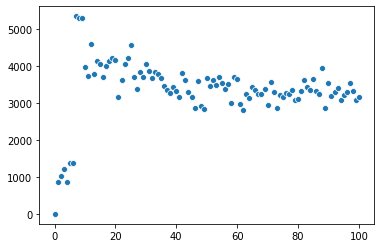

In [359]:
sns.scatterplot(range(len(value_array)),value_array)


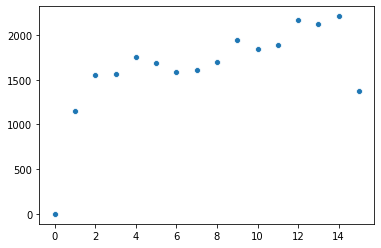

In [163]:
sns.scatterplot(range(len(value_array)),value_array)

In [174]:
def run(iterations):
    values = []
    for iteration in range(iterations):
        cash = [1000]
        position = [0]
        value =[1000]
        for t in range(len(data)- 60):
            # define current environment/state (s) and next environment (s1)
            s = data[t:t+60]
            s_trans = np.expand_dims(np.array([s]),2)
            s1 = data[t+1:t+61]
            # update cash and position metrics
            def a_is_0():
                if cash[-1] == 0:
                    cash.append(position[-1]*s1[-1])
                    position.append(0)
                    value.append(cash[-1])
                else:
                    cash.append(cash[-1])
                    position.append(0)
                    value.append(cash[-1])
            def a_is_1():
                if position[-1] == 0:
                    position.append(cash[-1]/s1[-1])
                    cash.append(0)
                    value.append(position[-1]*s1[-1])
                else:
                    position.append(position[-1])
                    value.append(position[-1]*s1[-1])

            # random walk
            a = a = np.argmax(model_predict.predict(s_trans))
            if a == 0:
                a_is_0()
            else:
                a_is_1()
        values.append(np.mean(value))
    return values, value

yolo, chikas = run(1)
print(yolo)
print(len(chikas), len(data))



[595.8757854078823]
141 200


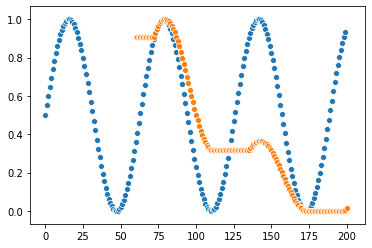

In [175]:
sns.scatterplot(np.arange(0,len(data),1),data-1)
sns.scatterplot(np.arange(60,60+len(chikas),1),(chikas-np.min(chikas))/(np.max(chikas)-np.min(chikas)))